In [9]:
#20/20 [==============================] - 15s 740ms/step - loss: 0.0718 - accuracy: 0.9770 - val_loss: 0.1276 -
# val_accuracy: 0.9597
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	'D:/datasets/rps/rps',
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)


model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.GlobalAveragePooling2D(),

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, epochs=25, steps_per_epoch=20, verbose = 1)

Found 2520 images belonging to 3 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Co

In [10]:
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape
from keras.models import Sequential,Model
cam_model  = Model(inputs=model.input,outputs=(model.layers[-5].output,model.layers[-1].output))
cam_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)      

In [17]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]
  print(features_for_img.shape)
  print(prediction.shape)
  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]
  print(class_activation_weights.shape)
  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (150/15, 150/15, 1), order=2)
  print(class_activation_features.shape)
  print(class_activation_weights.shape)
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(results[0][0])
#   print(f"prediction: {'human' if round(results[0][0]) else 'horse'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()

(1, 150, 150, 3)
(1, 15, 15, 512)
(1, 3)
(15, 15, 512)
(3,)
(512,)
(150, 150, 512)
(512,)
sigmoid output: [[0.15720367 0.4938055  0.34899086]]
0.15720367


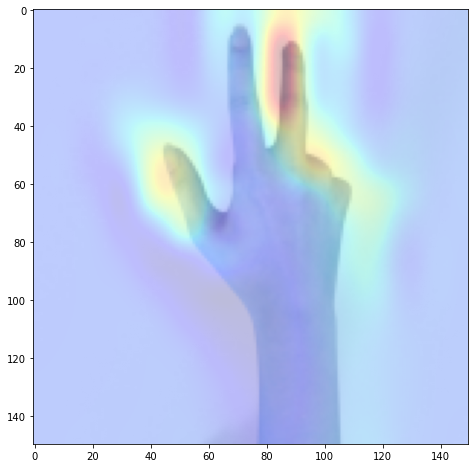

(1, 150, 150, 3)
(1, 15, 15, 512)
(1, 3)
(15, 15, 512)
(3,)
(512,)
(150, 150, 512)
(512,)
sigmoid output: [[0.15654254 0.50335234 0.34010515]]
0.15654254


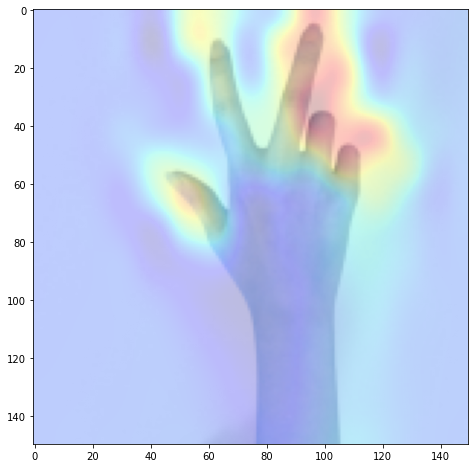

(1, 150, 150, 3)
(1, 15, 15, 512)
(1, 3)
(15, 15, 512)
(3,)
(512,)
(150, 150, 512)
(512,)
sigmoid output: [[0.14579524 0.5550296  0.29917514]]
0.14579524


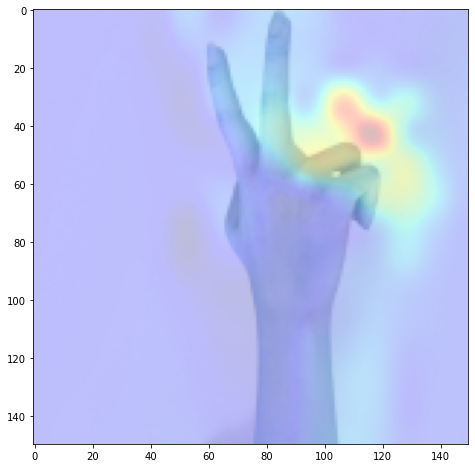

(1, 150, 150, 3)
(1, 15, 15, 512)
(1, 3)
(15, 15, 512)
(3,)
(512,)
(150, 150, 512)
(512,)
sigmoid output: [[0.11119632 0.7280559  0.1607478 ]]
0.111196324


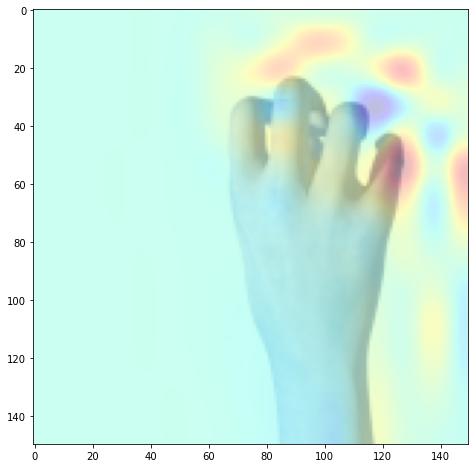

(1, 150, 150, 3)
(1, 15, 15, 512)
(1, 3)
(15, 15, 512)
(3,)
(512,)
(150, 150, 512)
(512,)
sigmoid output: [[0.02700528 0.93010515 0.04288966]]
0.027005276


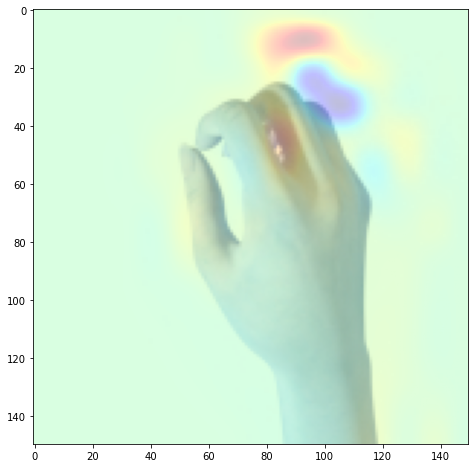

(1, 150, 150, 3)
(1, 15, 15, 512)
(1, 3)
(15, 15, 512)
(3,)
(512,)
(150, 150, 512)
(512,)
sigmoid output: [[0.15058382 0.00510907 0.84430707]]
0.15058382


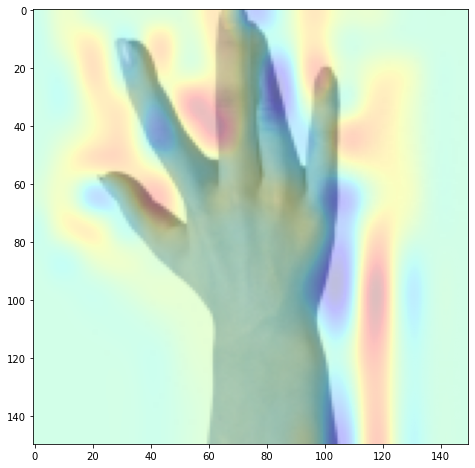

(1, 150, 150, 3)
(1, 15, 15, 512)
(1, 3)
(15, 15, 512)
(3,)
(512,)
(150, 150, 512)
(512,)
sigmoid output: [[0.14671393 0.54394466 0.30934134]]
0.14671393


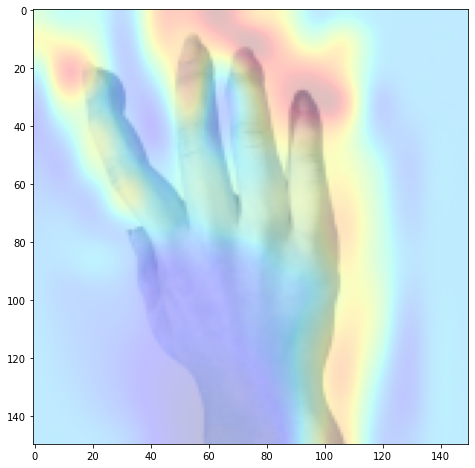

(1, 150, 150, 3)
(1, 15, 15, 512)
(1, 3)
(15, 15, 512)
(3,)
(512,)
(150, 150, 512)
(512,)
sigmoid output: [[0.99113667 0.00172482 0.00713851]]
0.99113667


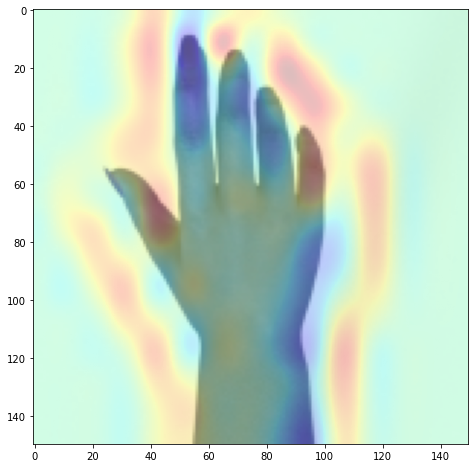

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (150,150)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)
  print(tensor_image.shape)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  print(features.shape)
  print(results.shape)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('D:/datasets/rps/rps/scissors/scissors01-000.png')
convert_and_classify('D:/datasets/rps/rps/scissors/scissors01-035.png')
convert_and_classify('D:/datasets/rps/rps/scissors/scissors01-116.png')
convert_and_classify('D:/datasets/rps/rps/rock/rock01-024.png')
convert_and_classify('D:/datasets/rps/rps/rock/rock01-044.png')
convert_and_classify('D:/datasets/rps/rps/paper/paper01-004.png')
convert_and_classify('D:/datasets/rps/rps/paper/paper04-017.png')
convert_and_classify('D:/datasets/rps/rps/paper/paper05-112.png')